# Separability and Hidden Layers

The goal of this module is to demonstrate how a neural network makes data separable if it isn't already.

You will:
* become familiar with the basic functioning of a simple deep network
* learn to view a network as a composition of functions
* explore the concept of "representation learning"

Much credit goes to [http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/](http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/) in inspiring these exercises. It is highly recommended reading.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# We'll use our handy decision boundary plot function from last time
def plot_decision_boundary(model, X, y):
    X_max = X.max(axis=0)
    X_min = X.min(axis=0)
    xticks = np.linspace(X_min[0], X_max[0], 100)
    yticks = np.linspace(X_min[1], X_max[1], 100)
    xx, yy = np.meshgrid(xticks, yticks)
    ZZ = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = ZZ[:,0] >= 0.5
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots()
    ax = plt.gca()
    ax.contourf(xx, yy, Z, cmap=plt.cm.bwr, alpha=0.2)
    ax.scatter(X[:,0], X[:,1], c=y[:,0], alpha=0.4)


## Learning non-separable data

Let's take a look at a more challenging dataset, one that is not linearly separable.

Using TensorFlow backend.


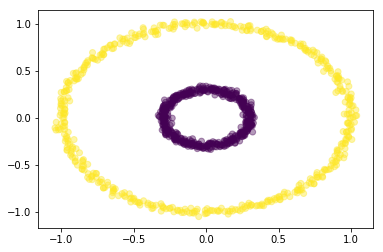

In [2]:
from sklearn.datasets import make_blobs, make_circles
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

X, y = make_circles(n_samples=1000,
                    noise=0.02,
                    factor=0.3)
y = np_utils.to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y)

plt.scatter(X[:,0], X[:,1], c=y[:,0], alpha=0.4)

Let's use the model we build last time on this data.

Epoch 1/200
750/750 [==============================] - 0s - loss: 0.7653 - acc: 0.5013     
Epoch 2/200
750/750 [==============================] - 0s - loss: 0.7406 - acc: 0.5187     
Epoch 3/200
750/750 [==============================] - 0s - loss: 0.7232 - acc: 0.5200     
Epoch 4/200
750/750 [==============================] - 0s - loss: 0.7124 - acc: 0.5307     
Epoch 5/200
750/750 [==============================] - 0s - loss: 0.7052 - acc: 0.5320     
Epoch 6/200
750/750 [==============================] - 0s - loss: 0.7009 - acc: 0.5467     
Epoch 7/200
750/750 [==============================] - 0s - loss: 0.6982 - acc: 0.5347     
Epoch 8/200
750/750 [==============================] - 0s - loss: 0.6965 - acc: 0.5760     
Epoch 9/200
750/750 [==============================] - 0s - loss: 0.6951 - acc: 0.5400     
Epoch 10/200
750/750 [==============================] - 0s - loss: 0.6948 - acc: 0.6413     
Epoch 11/200
750/750 [==============================] - 0s - loss: 0.6943 - acc

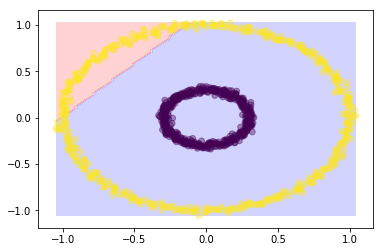

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model0 = Sequential()
model0.add(Dense(2, input_dim=2, activation='softmax'))

model0.compile(loss='categorical_crossentropy',
               optimizer=SGD(lr=0.04),
               metrics=['accuracy'])

model0.fit(X_train, y_train, nb_epoch=200, batch_size=16)
result = model0.evaluate(X_test, y_test)
print 'Test set loss: ', result[0]
print 'Test set accuracy: ', result[1]

plot_decision_boundary(model0, X, y)

The model doesn't do nearly as well, which is no surprise. The model isn't **expressive** enough to represent a more complicated decision boundary.

- - - 
### Exercise 1 - the model's strategy

Though our model doesn't have agency or a mind or it's own, it is a nice shorthand to talk about what the model is "trying" to do in a given situation. Based on the decision boundary plot, can you explain what the model's strategy is and why it gets the accuracy that it does? Try training the model a few times to see what other solutions it finds. Is there a solution that gives the best accuracy?
- - -




### Exercise 2 - expressiveness and structure

Recalling the structure of our model that you already sketched out, can you explain why this model can only make a linear decision boundary?


## Adding a hidden layer

We can make our model more expressive by adding a hidden layer. As we will see, this expands the expressiveness and representational capacity of the model, giving it enough power to separate the data.

- - -
### Exercise 3 - add a hidden layer

Below is the model specification we used already. Modify it in place to:

1. make the first layer 3 dimensional rather than 2 dimensional
2. add a "relu" `Activation` layer and a `Dense` layer that feeds into the last softmax layer. 

Hint: the `Dense` layer will not need to specify an `input_dim` since Keras will know the input dimension from the previous layer already.
- - -

<a id="compile"></a>

In [4]:
# Edit the model below to add new 3-dimensional hidden layer
model1 = Sequential()
model1.add(Dense(3, input_dim=2)) # Change the hidden layer to be 3 dimensional
# Add a 'relu' layer and Dense layer with an output of 2 dimensions
model1.add(Activation('relu'))
model1.add(Dense(2)) # Change the hidden layer to be 3 dimensional
model1.add(Activation('softmax'))

model1.compile(loss='categorical_crossentropy',
               optimizer=SGD(lr=0.04),
               metrics=['accuracy'])
model1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_2 (Dense)                  (None, 3)             9           dense_input_2[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 3)             0           dense_2[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 2)             8           activation_1[0][0]               
____________________________________________________________________________________________________
activation_2 (Activation)        (None, 2)             0           dense_3[0][0]                    
Total params: 17
Trainable params: 17
Non-trainable params: 0
_____________________________

### Exercise 4 - a more expressive structure

From the summary, check that your new model 1) has the same input and output dimension as before and 2) has 17 parameters. 

Draw this new model. Is it clear where all of the parameters are?


Epoch 1/20
750/750 [==============================] - 0s - loss: 0.7605 - acc: 0.3613     
Epoch 2/20
750/750 [==============================] - 0s - loss: 0.7204 - acc: 0.1827     
Epoch 3/20
750/750 [==============================] - 0s - loss: 0.6960 - acc: 0.4320     
Epoch 4/20
750/750 [==============================] - 0s - loss: 0.6861 - acc: 0.6453     
Epoch 5/20
750/750 [==============================] - 0s - loss: 0.6780 - acc: 0.5920     
Epoch 6/20
750/750 [==============================] - 0s - loss: 0.6703 - acc: 0.5560     
Epoch 7/20
750/750 [==============================] - 0s - loss: 0.6626 - acc: 0.6360     
Epoch 8/20
750/750 [==============================] - 0s - loss: 0.6553 - acc: 0.5773     
Epoch 9/20
750/750 [==============================] - 0s - loss: 0.6481 - acc: 0.6013     
Epoch 10/20
750/750 [==============================] - 0s - loss: 0.6410 - acc: 0.6280     
Epoch 11/20
750/750 [==============================] - 0s - loss: 0.6336 - acc: 0.6520   

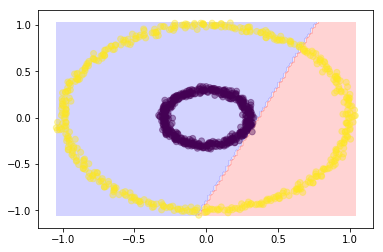

In [5]:
model1.fit(X_train, y_train, nb_epoch=20, batch_size=16)
plot_decision_boundary(model1, X, y)

result = model1.evaluate(X_test, y_test)
print 'Test set loss: ', result[0]
print 'Test set accuracy: ', result[1]

Your model should have done quite well. If not, you can reset and recompile the model (by running the cell where you defined the model) and train it again. Results vary from run to run, so train the network a few times to see how well it does (since we are not training the model very long, it might actually do quite badly on some of the runs). 

Retrain the model until you get a pretty high accuracy, then let's take a peak inside of the network to find out how this model can build a non-linear decision boundary.

## Representation Learning: inspecting the output of the hidden layer

When you added the hidden layer in the last model, you allowed the model to **re-represent** the input data before the final softmax decision layer. Let's take a look at this representation by looking at the activation of the units at the hidden layer. First, it is useful to know how to print out a model's layers:

In [96]:
model1.layers

In order to extract the activations at the hidden layer from Keras, we can [create a function](http://keras.io/getting-started/faq/#how-can-i-visualize-the-output-of-an-intermediate-layer) where we specify what layer we would like to "extract" the value of like so:

In [17]:
from keras import backend as K

get_hidden_layer_output = K.function([model1.layers[0].input],
                                     [model1.layers[1].output])
H = get_hidden_layer_output([X_test])[0]

print H.shape

(250, 3)


Naturally, our data is 3-dimensional, which is the dimension of the hidden layer of the model.

In [20]:
%matplotlib notebook

In [21]:
from mpl_toolkits.mplot3d import Axes3D

# A helper function to make a 3d scatter plot
def plot_3d_representation(X, y):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,0], X[:,1], X[:,2], c=y[:,0], alpha=0.2)
    ax.view_init(60, 30)

plot_3d_representation(H, y_test)

<IPython.core.display.Javascript object>

What do you see? Are the classes linearly separable now? Discuss what you think is happening with a partner or instructor.

## Adding capacity

We added a hidden layer with 3 dimensions, but we can give the model more capacity by using more dimensions. Maybe you noticed that the 3-dimensional model didn't always find a good solution on every run. Expanding the dimension of the hidden layer - giving the layer more representational capacity - should mostly fix that problem.

### Exercise 5 - expanding the hidden layer

Build a new model with a few more hidden units but is otherwise identical and train it on the circle data. How does this model perform compared to the previous model after training?

What is different about the accuracy of the model over the course of training? Can your model get perfect accuracy?

In [10]:
# Define model2 here with  some more hidden units and train it on the circle data.

model2 = Sequential()
model2.add(Dense(3, input_dim=2, activation='relu')) # Change the hidden layer to be 3 dimensional
model2.add(Dense(3, activation='relu'))
model2.add(Dense(2, activation='softmax'))

In [11]:
model2.compile(loss='categorical_crossentropy',
               optimizer=SGD(lr=0.04),
               metrics=['accuracy'])
model2.summary()
model2.fit(X_train, y_train, nb_epoch=100, batch_size=16)
plot_decision_boundary(model2, X, y)

result = model2.evaluate(X_test, y_test)
print 'Test set loss: ', result[0]
print 'Test set accuracy: ', result[1]

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_4 (Dense)                  (None, 3)             9           dense_input_3[0][0]              
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 3)             12          dense_4[0][0]                    
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 2)             8           dense_5[0][0]                    
Total params: 29
Trainable params: 29
Non-trainable params: 0
____________________________________________________________________________________________________
Epoch 1/100
750/750 [==============================] - 0s - loss: 0.7132 - acc: 0.4827     
Epoch 2/100
750/750 [=================

<IPython.core.display.Javascript object>

 32/250 [==>...........................] - ETA: 0sTest set loss:  0.00412603428774
Test set accuracy:  1.0


<IPython.core.display.Javascript object>

In [12]:
from keras import backend as K

get_hidden_layer_output = K.function([model2.layers[0].input],
                                     [model2.layers[0].output])
H2 = get_hidden_layer_output([X_test])[0]

print H2.shape


(250, 3)


In [13]:

from mpl_toolkits.mplot3d import Axes3D
# A helper function to make a 3d scatter plot
def plot_3d_representation(X, y):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:,0], X[:,1], X[:,2], c=y[:,0], alpha=0.2)
    ax.view_init(60, 30)

plot_3d_representation(H2, y_test)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>